In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import sys
from pathlib import Path
ROOT_PATH = Path().resolve().parent
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))
DIR_PATH = ROOT_PATH.joinpath('research')

C:\Users\jaakk\code\AutoEq
C:\Users\jaakk\code\AutoEq\research


In [15]:
from glob import glob
import numpy as np
import scipy
import matplotlib.pyplot as plt
import PyPDF2
from frequency_response import FrequencyResponse
from biquad import digital_coeffs, peaking

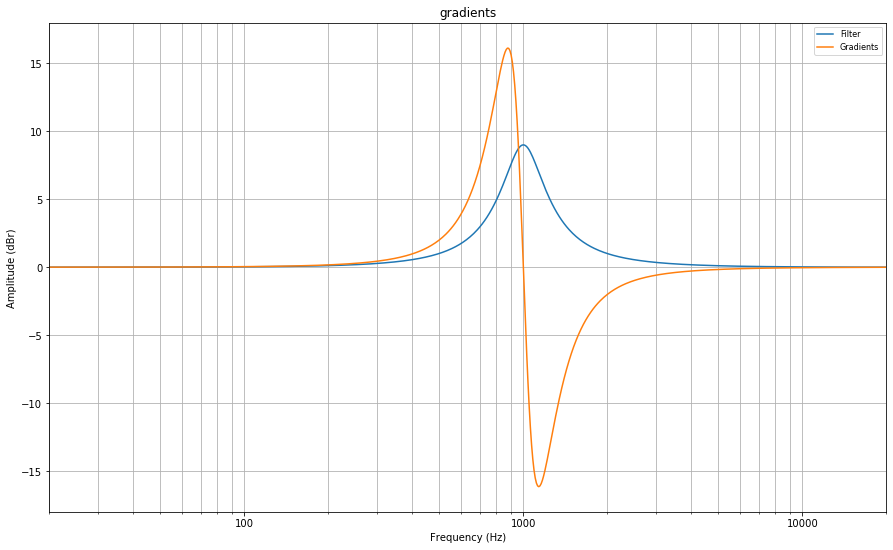

In [257]:
fc = [1000]
Q = [2.0]
gain = [9]
fs = 48000
fr = FrequencyResponse(name='peaking')
c = np.zeros(fr.frequency.shape)
for __fc, __Q, __gain in zip(fc, Q, gain):
    a0, a1, a2, b0, b1, b2 = peaking(__fc, __Q, __gain, fs=fs)
    c += digital_coeffs(fr.frequency, fs, a0, a1, a2, b0, b1, b2)
fr.raw = c


def log_log_gradient(f0, f1, g0, g1):
    octaves = np.log(f1 / f0) / np.log(2)
    gain = g1 - g0
    return gain / octaves


def gradient_array(_frequency, _gain):
    _gradients = []
    for _i in range(len(_frequency)):
        _g = []
        if _i > 0:
            _g.append(log_log_gradient(_frequency[_i - 1], _frequency[_i], _gain[_i - 1], _gain[_i]))
        if _i < len(fr.raw) - 1:
            _g.append(log_log_gradient(_frequency[_i], _frequency[_i + 1], _gain[_i], _gain[_i + 1]))
        _gradients.append(np.mean(_g))
    return _gradients


gradients = gradient_array(fr.frequency, fr.raw)
gr = FrequencyResponse(name='gradients', frequency=fr.frequency.copy(), raw=gradients)

fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
fr.plot_graph(fig=fig, ax=ax, raw_plot_kwargs={'color': 'C0', 'label': 'Filter', 'linewidth': 1.5}, show=False)
gr.plot_graph(fig=fig, ax=ax, raw_plot_kwargs={'color': 'C1', 'label': 'Gradients', 'linewidth': 1.5}, show=False)
ax.set_ylim([np.floor(np.min(gr.raw) * 1.1), np.ceil(np.max(gr.raw) * 1.1)])
plt.show()

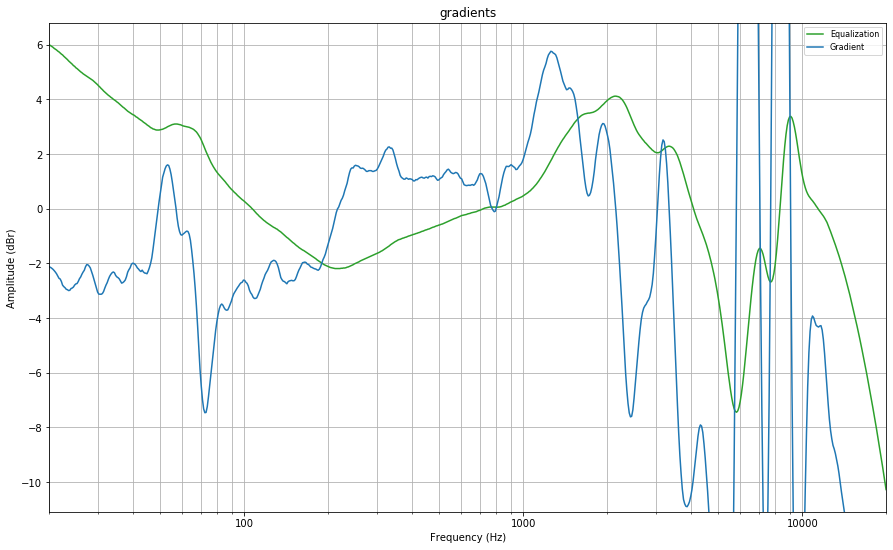

In [121]:
fp = ROOT_PATH.joinpath('results', 'oratory1990', 'harman_over-ear_2018', 'Sennheiser HD 800', 'Sennheiser HD 800.csv')
#fp = ROOT_PATH.joinpath('results', 'crinacle', 'harman_in-ear_2019v2', 'Custom Art FIBAE 3', 'Custom Art FIBAE 3.csv')

fr = FrequencyResponse.read_from_csv(fp)
fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
fr.plot_graph(
    fig=fig, ax=ax,
    raw=False, smoothed=False, error=False, error_smoothed=False, target=False, equalized=False,
    parametric_eq=False, fixed_band_eq=False, equalization_plot_kwargs={'linewidth': 1.5, 'color': 'C2'},
    show=False)
gr = FrequencyResponse(name='gradients', frequency=fr.frequency.copy(), raw=gradient_array(
    fr.frequency, fr.equalization
))
gr.smoothen_fractional_octave(window_size=1/6, treble_window_size=1/6)
gr.plot_graph(fig=fig, ax=ax, raw=False, smoothed_plot_kwargs={'color': 'C0', 'label': 'Gradient', 'linewidth': 1.5}, show=False)
plt.show()


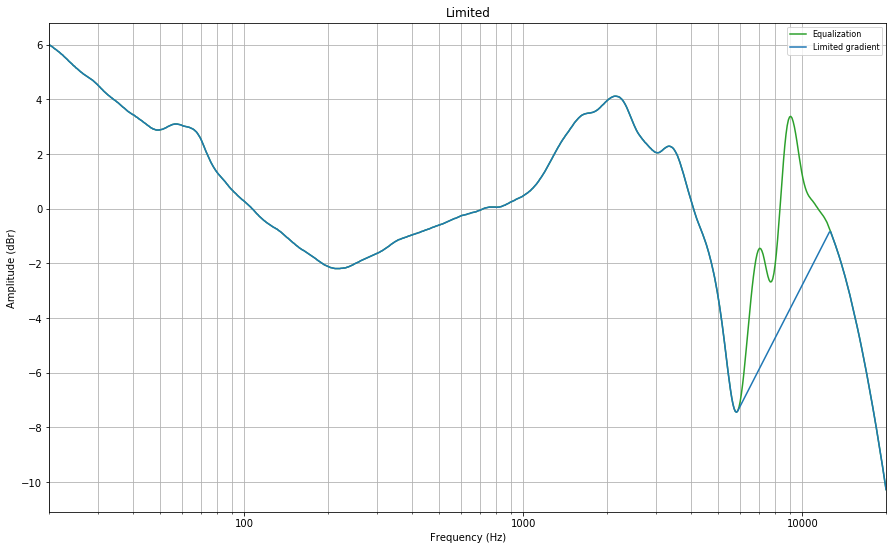

In [122]:
limited = []
for i in range(len(fr.frequency)):
    if i == 0:
        limited.append(fr.equalization[i])
    else:
        gradient = log_log_gradient(fr.frequency[i], fr.frequency[i - 1], fr.equalization[i], limited[-1])
        gradient = np.min([gradient, 6.0])
        octaves = np.log(fr.frequency[i] / fr.frequency[i - 1]) / np.log(2)
        limited.append(limited[-1] + gradient * octaves)
gr = FrequencyResponse(name='Limited', frequency=fr.frequency.copy(), raw=limited)

fig, ax = plt.subplots()
fig.set_size_inches(15, 9)
fr.plot_graph(
    fig=fig, ax=ax,
    raw=False, smoothed=False, error=False, error_smoothed=False, target=False, equalized=False,
    parametric_eq=False, fixed_band_eq=False, equalization_plot_kwargs={'linewidth': 1.5, 'color': 'C2'},
    show=False)
gr.plot_graph(fig=fig, ax=ax, raw=True, raw_plot_kwargs={'color': 'C0', 'label': 'Limited gradient', 'linewidth': 1.5}, show=False)
plt.show()

[ 11  14  26  56 456 519 559 645]
Backward start index: 50 = 12255.08


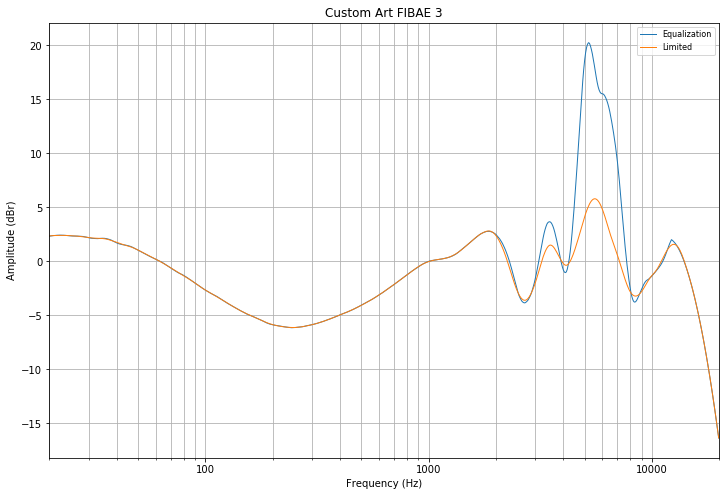

In [165]:
fp = ROOT_PATH.joinpath('measurements', 'crinacle', 'data', 'inear', 'Custom Art FIBAE 3', 'Custom Art FIBAE 3.csv')
fr = FrequencyResponse.read_from_csv(fp)
target = FrequencyResponse.read_from_csv(ROOT_PATH.joinpath('compensation', 'harman_in-ear_2019v2.csv'))
fr.compensate(target)
#fr.smoothen_fractional_octave(window_size=1/6, treble_window_size=1/6)
fr.smoothen_fractional_octave(
    window_size=1/3,
    treble_window_size=1.4,
    treble_f_lower=6000,
    treble_f_upper=12000
)
fr.raw = fr.error_smoothed.copy()
fr.reset()
fr.raw /= -1
peaks = scipy.signal.find_peaks(fr.raw)[0]
print(peaks)
backward_start_index = len(fr.frequency) - peaks[-1]
print(f'Backward start index: {backward_start_index} = {fr.frequency[-backward_start_index]}')

max_gradient = 18.0

limited_forward = []
for i in range(len(fr.frequency)):
    if i == 0:
        limited_forward.append(fr.raw[i])
    else:
        gradient = log_log_gradient(fr.frequency[i], fr.frequency[i - 1], fr.raw[i], limited_forward[-1])
        gradient = np.min([gradient, max_gradient])
        octaves = np.log(fr.frequency[i] / fr.frequency[i - 1]) / np.log(2)
        limited_forward.append(limited_forward[-1] + gradient * octaves)
        
limited_backward = []
frequency = np.flip(fr.frequency)
raw = np.flip(fr.raw)
for i in range(len(frequency)):
    if i < backward_start_index:
        limited_backward.append(raw[i])
    else:
        gradient = log_log_gradient(frequency[i], frequency[i - 1], raw[i], limited_backward[-1])
        #gradient = np.min([gradient, max_gradient])
        gradient = np.max([gradient, -max_gradient])
        octaves = np.log(frequency[i] / frequency[i - 1]) / np.log(2)
        limited_backward.append(limited_backward[-1] + gradient * octaves)
limited_backward = np.flip(limited_backward)
        
gr = FrequencyResponse(name='Limited', frequency=fr.frequency.copy(), raw=np.min(np.vstack([limited_forward, limited_backward]), axis=0))
gr.smoothen_fractional_octave(window_size=1/2, treble_window_size=1/2)
gr.raw = gr.smoothed.copy()
gr.reset()

fig, ax = fr.plot_graph(show=False, raw_plot_kwargs={'color': 'C0', 'label': 'Equalization'}, smoothed_plot_kwargs={'color': 'C0', 'linestyle': 'dashed', 'linewidth': 1.0})
gr.plot_graph(fig=fig, ax=ax, show=False, raw_plot_kwargs={'color': 'C1', 'label': 'Limited'})
ax.set_title(fr.name)
plt.show()

In [333]:
class FR(FrequencyResponse):
    @staticmethod
    def limited_forward_delta(x, y, limit, start_index=0):
        limited = []
        for i in range(len(x)):
            if i < start_index:
                limited.append(y[i])
            else:
                gradient = log_log_gradient(x[i], x[i - 1], y[i], limited[-1])
                if limit >= 0.0:
                    gradient = np.min([gradient, limit])
                else:
                    gradient = np.max([gradient, limit])
                octaves = np.log(x[i] / x[i - 1]) / np.log(2)
                limited.append(limited[-1] + gradient * octaves)
        return np.array(limited)

    @classmethod
    def limited_delta(cls, x, y, limit):
        peak_finder = cls(name='peak_finder', frequency=x, raw=y)
        peak_finder.smoothen_fractional_octave(window_size=1/12, treble_window_size=1/3, treble_f_lower=9000, treble_f_upper=11000)
        peaks = scipy.signal.find_peaks(-peak_finder.smoothed)[0]
        forward_start = peaks[0]
        backward_start = len(x) - peaks[-1] - 1
        
        limited_forward = cls.limited_forward_delta(x, y, limit, start_index=forward_start)
        limited_backward = cls.limited_forward_delta(np.flip(x), np.flip(y), -limit, start_index=backward_start)
        limited_backward = np.flip(limited_backward)
        
        _fr = FrequencyResponse(name='limiter', frequency=x.copy(), raw=np.min(np.vstack([limited_forward, limited_backward]), axis=0))
        _fr.smoothen_fractional_octave(window_size=1/6, treble_window_size=1/6)
        return _fr.smoothed.copy()
    
    def equalize(self,
                 max_gain=6.0,
                 smoothen=True,
                 treble_f_lower=5000,
                 treble_f_upper=10000,
                 treble_max_gain=6.0,
                 treble_gain_k=1.0):
        """Creates equalization curve and equalized curve.

        Args:
            max_gain: Maximum positive gain in dB
            smoothen: Smooth kinks caused by clipping gain to max gain?
            treble_f_lower: Lower frequency boundary for transition region between normal parameters and treble parameters
            treble_f_upper: Upper frequency boundary for transition reqion between normal parameters and treble parameters
            treble_max_gain: Maximum positive gain in dB in treble region
            treble_gain_k: Coefficient for treble gain, positive and negative. Useful for disbling or reducing \
                           equalization power in treble region. Defaults to 1.0 (not limited).
        """
        # Limit gain
        eq_target = np.clip(self.error * -1, None, max_gain)
        
        # Limit delta
        limited = self.limited_delta(self.frequency, eq_target, 6.0)
        self.equalization = limited
        self.parametric_eq = eq_target

        # Equalized
        self.equalized_raw = self.raw + self.equalization
        if len(self.smoothed):
            self.equalized_smoothed = self.smoothed + self.equalization

In [ ]:
onear_target = FrequencyResponse.read_from_csv(ROOT_PATH.joinpath('compensation', 'harman_over-ear_2018_wo_bass.csv'))
inear_target = FrequencyResponse.read_from_csv(ROOT_PATH.joinpath('compensation', 'harman_in-ear_2019v2_wo_bass.csv'))

headphones = [
    'Focal Utopia',
    'HIFIMAN Arya',
    'Sennheiser HD 800',
    'Audeze LCD-4',
]
headphones = [ROOT_PATH.joinpath('measurements', 'oratory1990', 'data', 'onear', p) for p in headphones]

iems = [
    '64 Audio Tia Fourte (sample 1)',
    'qdc Gemini',
    'Custom Art FIBAE 3'
]
iems = [ROOT_PATH.joinpath('measurements', 'crinacle', 'data', 'inear', p) for p in iems]

for fp in headphones:
    fr = FR.read_from_csv(glob(str(fp.joinpath('*.csv')))[0])
    fr.process(compensation=inear_target, bass_boost_gain=6.0, bass_boost_fc=105, bass_boost_q=0.7, equalize=True, min_mean_error=True)
    fig, ax = fr.plot_graph(show=False, raw=False, smoothed=False, error_smoothed=True)
    ax.set_ylim([-10, 10])
    ax.set_xlim([5000, 20000])

for fp in iems:
    fr = FR.read_from_csv(glob(str(fp.joinpath('*.csv')))[0])
    fr.process(compensation=inear_target, bass_boost_gain=6.0, bass_boost_fc=105, bass_boost_q=0.7, equalize=True, min_mean_error=True)
    fig, ax = fr.plot_graph(show=False, raw=False, smoothed=False, error_smoothed=False)
    ax.set_ylim([-10, 10])

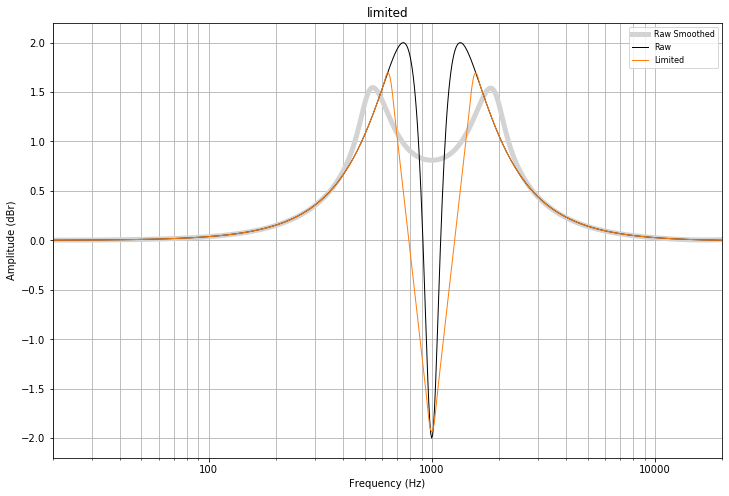

In [345]:
fc = [1000, 1000]
Q = [1.0, 4.0]
gain = [4.0, -6.0]
fs = 48000
fr = FR(name='peaking')
c = np.zeros(fr.frequency.shape)
for __fc, __Q, __gain in zip(fc, Q, gain):
    a0, a1, a2, b0, b1, b2 = peaking(__fc, __Q, __gain, fs=fs)
    c += digital_coeffs(fr.frequency, fs, a0, a1, a2, b0, b1, b2)
fr.raw = c
fr.smoothen_fractional_octave(window_size=2, treble_window_size=2)
target = FrequencyResponse(name='target', frequency=fr.frequency, raw=np.zeros(fr.frequency.shape))
limited = FR.limited_delta(fr.frequency, fr.raw, 6.0)
limited = FrequencyResponse(name='limited', frequency=fr.frequency, raw=limited)

fig, ax = fr.plot_graph(show=False)
limited.plot_graph(fig=fig, ax=ax, raw_plot_kwargs={'color': 'C1', 'label': 'Limited'}, show=False)
plt.show()